In [ ]:
# import other libraries
import pandas as pd
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")  # Ajouter src/ au chemin système
if src_path not in sys.path:
    sys.path.append(src_path)
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import warnings
from rasterio.windows import from_bounds
from pyproj import Transformer
from skgstat import Variogram
from scipy.stats import skewnorm, rankdata
import gstools as gs
from geopy.distance import geodesic
from scipy.stats import skew
from simulation_functions import (
    simulate_spatial_data,
    generate_datasets_with_square_grids,
    export_datasets_to_csv,
    check_distances
)
warnings.filterwarnings('ignore')

In [7]:
data_link = '../data/real/pm10_avg_22.tif'
# Afficher les métadonnées
with rasterio.open(data_link) as src:
    # Afficher les métadonnées principales
    print("Métadonnées du fichier :")
    print(src.meta)
    
    # Afficher la largeur et la hauteur de l'image
    print("\nDimensions de l'image :")
    print("Largeur:", src.width)
    print("Hauteur:", src.height)
    
    # Afficher le nombre de couches (bands)
    print("\nNombre de couches :", src.count)
    
    # Afficher la résolution
    print("\nRésolution de l'image :", src.res)
    
    # Afficher les coordonnées de la zone d'emprise
    print("\nEmprise géographique :")
    print(src.bounds)
    
    # Afficher le système de projection
    print("\nSystème de projection :", src.crs)
    
    # Afficher la valeur "no data" si elle est définie
    print("\nValeur 'no data' :", src.nodata)


Métadonnées du fichier :
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4680, 'height': 4037, 'count': 1, 'crs': CRS.from_wkt('PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3035"]]'), 'transform': Affine(1000.0, 0.0, 2635999.999999999,
       0.0, -1000.0, 5423000.0)}

Dimensions de l'image :
Largeur: 4680
Hauteur: 4037

Nombre de couches : 1

Résolution de l'image : (1000.0, 1000.0)

Emprise géographique :
BoundingBox(left=2635999.

Valeur 'no data': -3.4028234663852886e+38


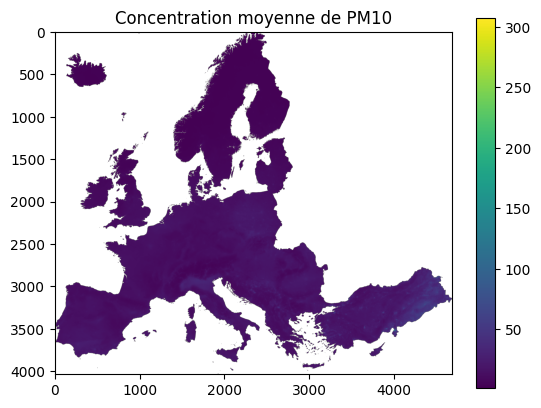

In [8]:
# Ouvrir le fichier .tif
with rasterio.open(data_link) as src:
    
    no_data_value = src.nodata
    print("Valeur 'no data':", no_data_value)

    # Lire les données
    data = src.read(1)
    # Remplacer la valeur "no data" par NaN
    if no_data_value is not None:
        data = np.where(data == no_data_value, np.nan, data)
    else:
        # Utilisons un seuil élevé si "no data" n'est pas défini
        data = np.where(data > 1e20, np.nan, data)

    # Afficher les données
    plt.imshow(data, cmap='viridis')
    plt.colorbar()
    plt.title("Concentration moyenne de PM10")
    plt.show()

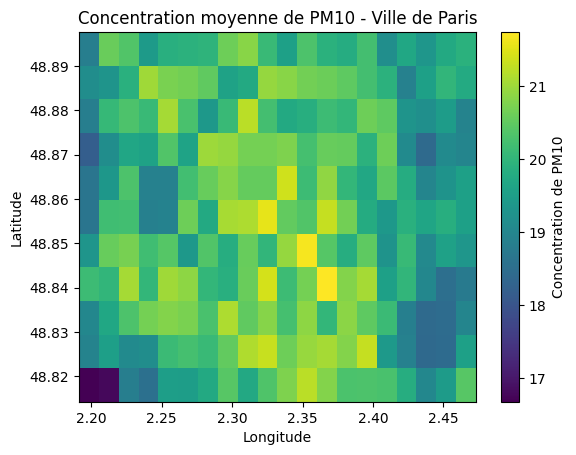

In [9]:
# Coordonnées géographiques pour la ville de Paris
min_lon, min_lat = 2.20, 48.80
max_lon, max_lat = 2.45, 48.92

# Transformer les coordonnées WGS84 vers le système projeté EPSG:3035
transformer_to_projected = Transformer.from_crs("EPSG:4326", "EPSG:3035", always_xy=True)
min_x, min_y = transformer_to_projected.transform(min_lon, min_lat)
max_x, max_y = transformer_to_projected.transform(max_lon, max_lat)

# Transformer inversement pour obtenir des coordonnées en degrés
transformer_to_geo = Transformer.from_crs("EPSG:3035", "EPSG:4326", always_xy=True)

# Ouvrir le fichier et extraire la zone d'intérêt
with rasterio.open(data_link) as src:
    window = from_bounds(min_x, min_y, max_x, max_y, src.transform)
    data_cropped = src.read(1, window=window)

    # Calculer les coordonnées des coins en latitude/longitude
    left, top = transformer_to_geo.transform(*src.xy(window.row_off, window.col_off))
    right, bottom = transformer_to_geo.transform(*src.xy(window.row_off + window.height, window.col_off + window.width))

    # Afficher l'image avec aspect ajusté
    plt.imshow(data_cropped, cmap='viridis', extent=(left, right, bottom, top), aspect='auto')
    plt.colorbar(label="Concentration de PM10")
    plt.title("Concentration moyenne de PM10 - Ville de Paris")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


In [10]:
# Ouvrir le fichier et extraire la zone d'intérêt
with rasterio.open(data_link) as src:
    window = from_bounds(min_x, min_y, max_x, max_y, src.transform)
    data_cropped = src.read(1, window=window)

    # Créer une liste pour stocker les données
    data_list = []
    
    # Parcourir chaque pixel dans la zone découpée
    for row in range(data_cropped.shape[0]):
        for col in range(data_cropped.shape[1]):
            # Obtenir les coordonnées projetées pour chaque pixel
            x, y = src.xy(window.row_off + row, window.col_off + col)
            # Convertir en latitude et longitude
            lon, lat = transformer_to_geo.transform(x, y)
            # Obtenir la valeur de PM10 pour ce pixel
            value = data_cropped[row, col]
            # Ajouter les informations dans la liste
            data_list.append((lat, lon, value))

# Convertir la liste en DataFrame pour un affichage structuré
df = pd.DataFrame(data_list, columns=["Latitude", "Longitude", "PM10 Concentration"])
print(df)

      Latitude  Longitude  PM10 Concentration
0    48.897649   2.191430           18.850513
1    48.898600   2.205002           20.576319
2    48.899550   2.218575           20.371670
3    48.900498   2.232149           19.427649
4    48.901444   2.245722           19.876755
..         ...        ...                 ...
215  48.822344   2.408818           20.279110
216  48.823269   2.422374           19.826250
217  48.824192   2.435929           19.019623
218  48.825113   2.449486           19.461554
219  48.826033   2.463042           20.427773

[220 rows x 3 columns]


Modèle exponential:
{'model': 'exponential', 'estimator': 'matheron', 'dist_func': 'euclidean', 'normalized_effective_range': np.float64(0.03786126668298833), 'normalized_sill': np.float64(0.6626440141695925), 'normalized_nugget': 0, 'effective_range': np.float64(0.13478781187128755), 'sill': np.float64(0.7554141713578326), 'nugget': 0, 'params': {'estimator': 'matheron', 'model': 'exponential', 'dist_func': 'euclidean', 'bin_func': 'even', 'normalize': False, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': False, 'maxlag': None, 'n_lags': 10, 'verbose': False}, 'kwargs': {}}
----------------------------------------


<Figure size 800x600 with 0 Axes>

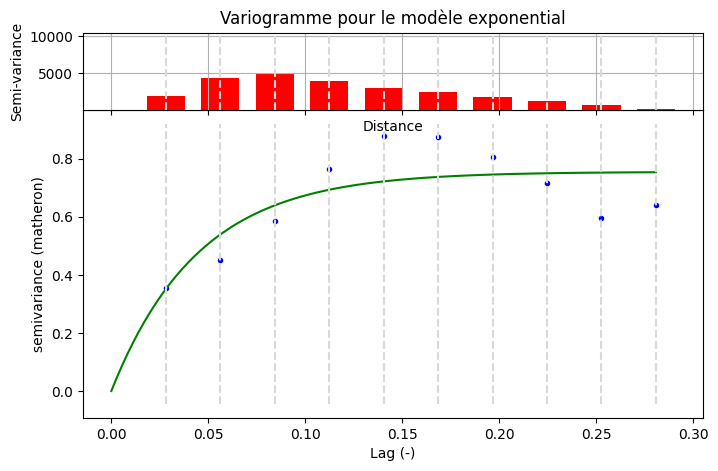

Modèle spherical:
{'model': 'spherical', 'estimator': 'matheron', 'dist_func': 'euclidean', 'normalized_effective_range': np.float64(0.03541090718234912), 'normalized_sill': np.float64(0.6599997072807438), 'normalized_nugget': 0, 'effective_range': np.float64(0.12606442186549097), 'sill': np.float64(0.7523996615236817), 'nugget': 0, 'params': {'estimator': 'matheron', 'model': 'spherical', 'dist_func': 'euclidean', 'bin_func': 'even', 'normalize': False, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': False, 'maxlag': None, 'n_lags': 10, 'verbose': False}, 'kwargs': {}}
----------------------------------------


<Figure size 800x600 with 0 Axes>

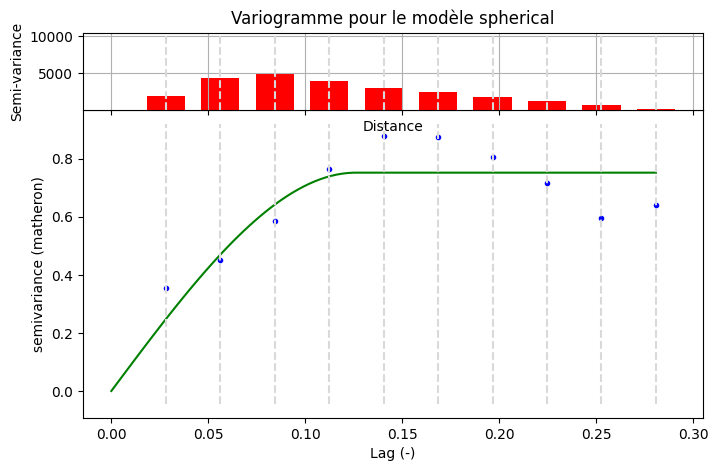

Modèle gaussian:
{'model': 'gaussian', 'estimator': 'matheron', 'dist_func': 'euclidean', 'normalized_effective_range': np.float64(0.02963629152415821), 'normalized_sill': np.float64(0.6518403499702743), 'normalized_nugget': 0, 'effective_range': np.float64(0.10550653045941838), 'sill': np.float64(0.7430979942487951), 'nugget': 0, 'params': {'estimator': 'matheron', 'model': 'gaussian', 'dist_func': 'euclidean', 'bin_func': 'even', 'normalize': False, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': False, 'maxlag': None, 'n_lags': 10, 'verbose': False}, 'kwargs': {}}
----------------------------------------


<Figure size 800x600 with 0 Axes>

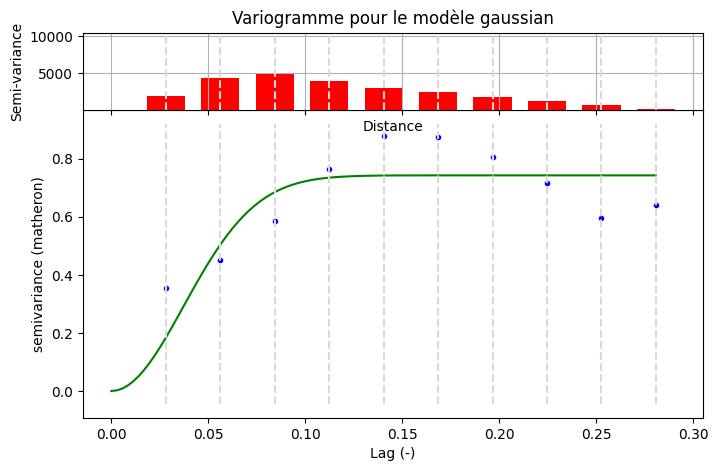

In [11]:
coordinates = df[["Longitude", "Latitude"]].values
values = df["PM10 Concentration"].values

# Créer le variogramme expérimental
# Nous allons utiliser plusieurs modèles pour voir lequel est le plus adapté
models = ['exponential', 'spherical', 'gaussian']
variograms = {}

for model in models:
    V = Variogram(coordinates, values, model=model)
    variograms[model] = V

    # Afficher les paramètres de chaque modèle
    print(f"Modèle {model}:")
    print(V.describe())
    print("-" * 40)

    # Visualiser le variogramme
    # Tracer le variogramme expérimental et le modèle ajusté
    plt.figure(figsize=(8, 6))
    V.plot(show=False)
    plt.title(f"Variogramme pour le modèle {model}")
    plt.xlabel("Distance")
    plt.ylabel("Semi-variance")
    plt.grid(True)
    plt.show()

# Des trois modèles, nous constatons que le modèle exponentiel capture une portée plus grande. Nous le 
# retiendrons pour notre variogramme empirique.


In [12]:
# Préparer les données
coordinates = df[["Longitude", "Latitude"]].values
values = df["PM10 Concentration"].values

# Créer le variogramme et ajuster un modèle pour extraire les paramètres
V = Variogram(coordinates, values, model='exponential')

# Extraire les paramètres
print(V.describe())

{'model': 'exponential', 'estimator': 'matheron', 'dist_func': 'euclidean', 'normalized_effective_range': np.float64(0.03786126668298833), 'normalized_sill': np.float64(0.6626440141695925), 'normalized_nugget': 0, 'effective_range': np.float64(0.13478781187128755), 'sill': np.float64(0.7554141713578326), 'nugget': 0, 'params': {'estimator': 'matheron', 'model': 'exponential', 'dist_func': 'euclidean', 'bin_func': 'even', 'normalize': False, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': False, 'maxlag': None, 'n_lags': 10, 'verbose': False}, 'kwargs': {}}


In [ ]:
# Paramètres de simulation
square_sizes = [9, 12, 15, 18, 21]
n_simulations = 1000
base_seed = 42

# Simulation
print("Génération des données spatiales simulées:")
datasets = generate_datasets_with_square_grids(
    square_sizes=square_sizes,
    n_simulations=n_simulations,
    base_seed=base_seed
)

# Export
print("Export des datasets en fichiers csv")
export_datasets_to_csv(datasets, output_folder="../data/simulated")

print("Terminé.")

Génération des données spatiales simulées:
Export des datasets en fichiers csv
Terminé.


In [31]:
max_distance = check_distances((2.20, 2.45), (48.80, 48.92))
print(max_distance)


22684.62624170485
